In [21]:
import pandas as pd
# *** <주제: 와인 품질 예측하기 ***


# Step0: 데이터 탐색

# 0-1. csv파일 읽기
wine = pd.read_csv('wine.csv')
# wine.head()
# wine.info()

# 0-2. 띄어쓰기가 있는 열은 언더바로 대체()
    # https://chat.openai.com/c/c4e830a2-72a1-464a-97c1-2592f719c808
wine.columns = wine.columns.str.replace(' ','_')
wine.head()
wine.describe()

# 0-3. 열이름 정렬하기
    # unique() 기억하기
wine.quality.value_counts()
sorted(wine.quality.unique()) # [3, 4, 5, 6, 7, 8, 9]


# Step1: 데이터 모델링

# 1-1. describe() 함수로 '타입'별 비교(레드, 화이트)
    # *그룹(group)객체 생성 및 집계(agg) 연산
    # (1)groupyby함수 - sql했을때ㅎㅎ
    # (2)뒤에 describe()함수 붙여야 함
    # (3)agg로 열 합치기
wine.groupby('type')['quality'].describe()
# wine.groupby('type')['quality'].mean()
# wine.groupby('type')['quality'].std()
wine.groupby('type')['quality'].agg(['mean', 'std'])

,mean,std
type,,
red,5.636023,0.807569
white,5.877909,0.885639


In [ ]:
! pip install statsmodels

In [48]:
# 1-2. t-검정과 회귀 분석으로 그룹 비교하기
    # (1)t-검정을 위해서는 scipy 라이브러리 패키지를 사용
    # (2)회귀 분석을 위해서는 statsmodels 라이브러리 패키지를 사용
    # (3)명령 프롬프트 창에서 다음과 같이 입력하여 statsmodels 패키지를 설치

from scipy import stats
from statsmodels.formula.api import ols, glm

red_wine_quality = wine.loc[wine['type'] == 'red', 'quality']
white_wine_quality = wine.loc[wine['type'] == 'white', 'quality']

# 1)scipy 패키지의 stats.ttest_ind() 함수를 사용하여 t-검정을 하고 두 그룹 간 차이를 확인
stats.ttest_ind(red_wine_quality, white_wine_quality, equal_var = False)
# TtestResult(statistic=-10.149363059143164, pvalue=8.168348870049682e-24, df=2950.750452166697)


# 2)선형 회귀 분석식의 종속 변수(y)와 독립 변수(x1~x10)를 구성
    # * ~ 앞에 나온게 y값이고, 뒤에 +로 연결된 fixed_acidity부터 alcohol까지가 x값들임
    # 여러줄 할때는 ''' '''
Rformula = '''quality ~ fixed_acidity + volatile_acidity + citric_acid + 
residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide +
density + pH + sulphates + alcohol'''

# 3)선형 회귀 모델 중에서 OLSOrdinary Least Squares 모델을 사용
    # 결국, 전처리만 잘하면 분석코드는 1줄로 해결이 가능
regression_result = ols(Rformula, data = wine).fit()

# 4)선형 회귀 분석과 관련된 통계값을 출력
regression_result.summary()

# 5)예측에 사용할 첫 번째 샘플 데이터 만들기
    # difference: quality와 type 열은 제외gkseksms EMt
sample1 = wine[wine.columns.difference(['quality', 'type'])]
sample1
sample1 = sample1[0:5][:] # ? 행과 열을 의미한것임 뒤의[:]는 얕은복사 아님ㅇㅇ
sample1

# 6)샘플 데이터를 위에서 만든 회귀 분석 모델인 'regression_result'의 예측 함수 predict()에 적용하여 수행
    # = 예측 결과값
sample1_predict = regression_result.predict(sample1)
sample1_predict
wine['quality'][:5]
sample1


# 7)회귀식에 사용한 독립 변수에 대입할 임의의 값을 딕셔너리 형태로 제작
data = {"fixed_acidity" : [8.5, 8.1], "volatile_acidity":[0.8, 0.5],
"citric_acid":[0.3, 0.4], "residual_sugar":[6.1, 5.8], "chlorides":[0.055,
0.04], "free_sulfur_dioxide":[30.0, 31.0], "total_sulfur_dioxide":[98.0,
99], "density":[0.996, 0.91], "pH":[3.25, 3.01], "sulphates":[0.4, 0.35],
"alcohol":[9.0, 0.88]}

# 8)딕셔너리 형태의 값과 sample1의 열 이름만 뽑아 데이터프레임으로 묶은 sample2를 제작
sample2 = pd.DataFrame(data, columns= sample1.columns)
sample2

# 9)샘플 데이터를 회귀 분석 모델 regression_result의 예측 함수 predict()에 적용하여 수행한 뒤,
    # 결과 예측값을 sample2_predict에 저장
sample2_predict = regression_result.predict(sample2)
sample2_predict


0    4.809094
1    7.582129
dtype: float64

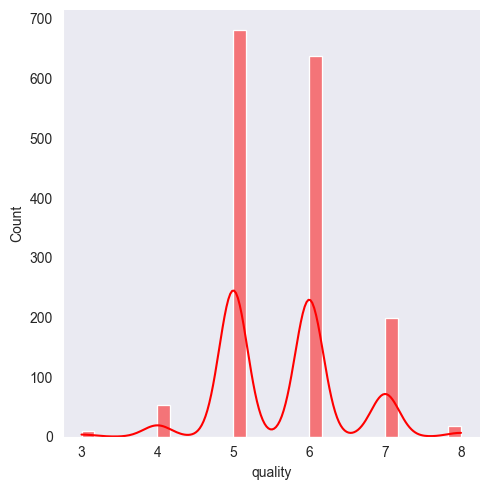

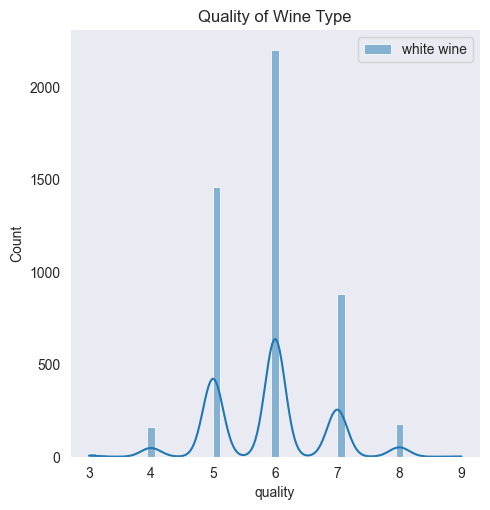

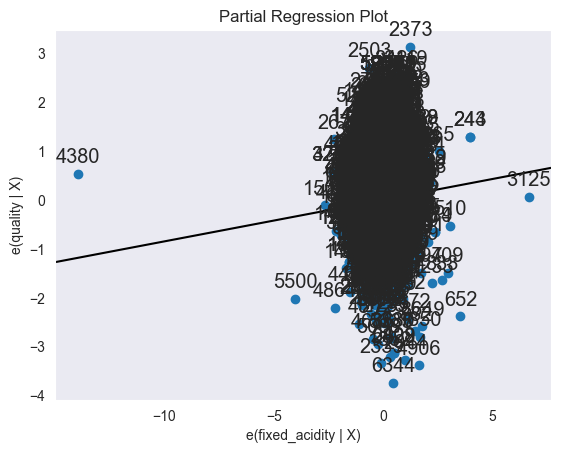

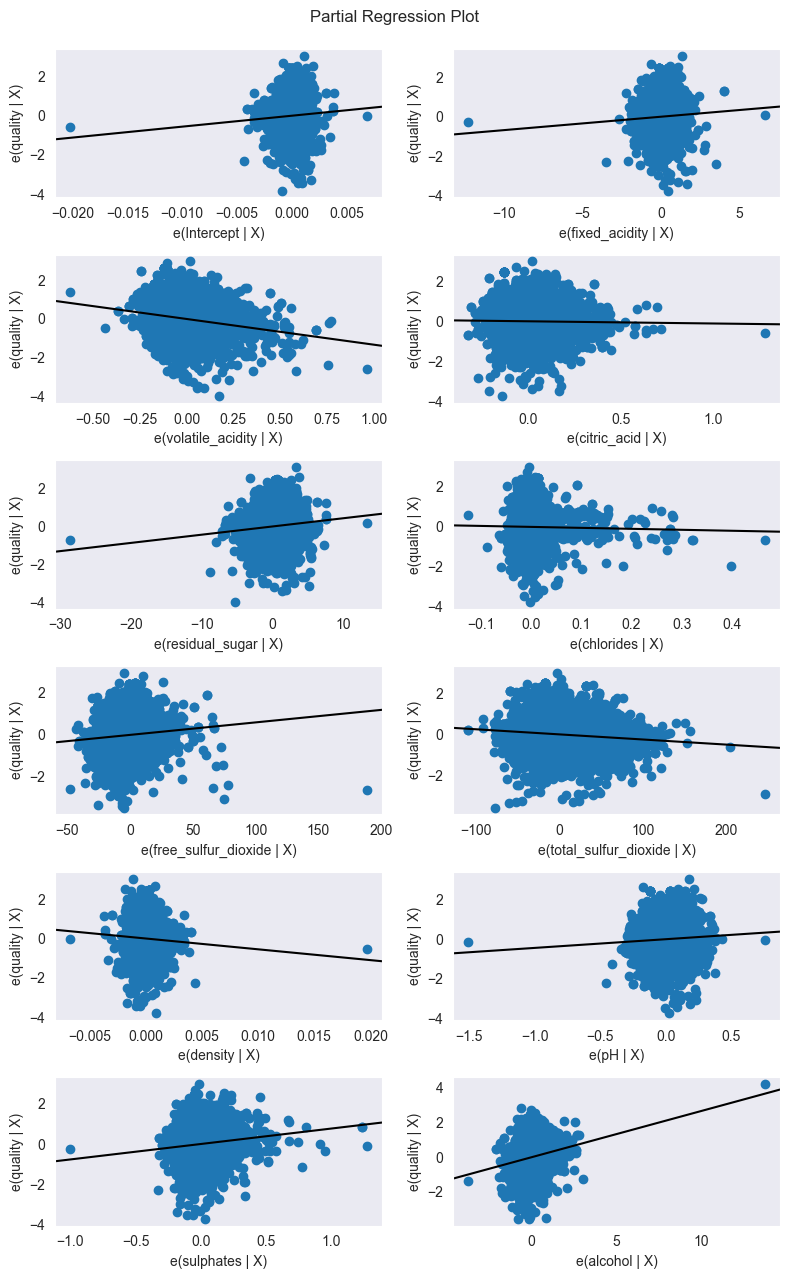

In [52]:
# Step2: 결과 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm # 부분 회귀 계산을 위해

# 1. 와인 유형에 따른 품질 등급 히스토그램 그리기
sns.set_style('dark') # 히스토그램 차트의 배경색 스타일을 설정
# 레드,화이트 와인에 대한 distplot 객체를 생성
sns.displot(red_wine_quality, kde = True, color = "red", label = 'redwine')
sns.displot(white_wine_quality, kde = True, label = 'white wine')
plt.title("Quality of Wine Type")
plt.legend() # 차트 범례를 설정
plt.show()
# ----------------------------

# 2. 부분 회귀 플롯으로 시각화하기
    # 독립 변수가 2개 이상인 경우에는 부분 회귀 플롯을 사용하여 하나의 독립 변수가
    # -> 종속 변수에 미치는 영향력을 시각화 함으로써 결과를 분석할 수 있음

# 1)부분 회귀에 사용한 독립 변수와 종속 변수를 제외한 나머지 변수 이름을 리스트 others로 추출
others = list(set(wine.columns).difference(set(["quality", "fixed_acidity"])))

# 2)나머지 변수는 고정하고 fixed_acidity가 종속 변수 quality에 미치는 영향에 부분회귀를 수행
p, resids = sm.graphics.plot_partregress("quality", "fixed_acidity", others, data = wine, ret_coords = True)
plt.show()

# 3)다중 선형 회귀 분석 결과를 가지고 있는 regression_result를 이용해 각 독립 변수의 부분 회귀 플롯을 구함
fig = plt.figure(figsize = (8, 13))
sm.graphics.plot_partregress_grid(regression_result, fig = fig)
plt.show()